In [260]:
import sys
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

sys.path.append("../tools/")

from feature_format import featureFormat, targetFeatureSplit
from tester import dump_classifier_and_data


from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score #score evaluation
from sklearn.model_selection import cross_val_predict #prediction
from sklearn import metrics

from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

import tester

## Data Setup

In [261]:
### Load the dictionary containing the dataset
with open("final_project_dataset.pkl", "rb") as data_file:
    data_dict = pickle.load(data_file)

Below we remove the outlier "TOTAL" and convert data to pandas dataframe.

In [262]:

data_dict.pop("TOTAL", 0)
enron_df = pd.DataFrame(data_dict)
enron_df = enron_df.T
enron_df.head()

,bonus,deferral_payments,deferred_income,director_fees,email_address,exercised_stock_options,expenses,from_messages,from_poi_to_this_person,from_this_person_to_poi,...,long_term_incentive,other,poi,restricted_stock,restricted_stock_deferred,salary,shared_receipt_with_poi,to_messages,total_payments,total_stock_value
METTS MARK,600000,NaN,NaN,NaN,mark.metts@enron.com,NaN,94299,29,38,1,...,NaN,1740,False,585062,NaN,365788,702,807,1061827,585062
BAXTER JOHN C,1200000,1295738,-1386055,NaN,NaN,6680544,11200,NaN,NaN,NaN,...,1586055,2660303,False,3942714,NaN,267102,NaN,NaN,5634343,10623258
ELLIOTT STEVEN,350000,NaN,-400729,NaN,steven.elliott@enron.com,4890344,78552,NaN,NaN,NaN,...,NaN,12961,False,1788391,NaN,170941,NaN,NaN,211725,6678735
CORDES WILLIAM R,NaN,NaN,NaN,NaN,bill.cordes@enron.com,651850,NaN,12,10,0,...,NaN,NaN,False,386335,NaN,NaN,58,764,NaN,1038185
HANNON KEVIN P,1500000,NaN,-3117011,NaN,kevin.hannon@enron.com,5538001,34039,32,32,21,...,1617011,11350,True,853064,NaN,243293,1035,1045,288682,6391065


In [263]:
# Replace all occurrences of Not Available with numpy not a number
enron_df = enron_df.replace({'NaN': np.nan})

missing_records_list = []

# Iterate through the columns
for col in list(enron_df.columns):
    # Select columns that should be numeric
    if col not in ['email_address', 'poi']:
        # Convert the data type to float
        enron_df[col] = enron_df[col].astype(float)
    if enron_df[col].count()< (enron_df.shape[0]/3.):
        missing_records_list.append(col)
        

## Data Exploration

In [264]:
enron_df.describe()

,bonus,deferral_payments,deferred_income,director_fees,exercised_stock_options,expenses,from_messages,from_poi_to_this_person,from_this_person_to_poi,loan_advances,long_term_incentive,other,restricted_stock,restricted_stock_deferred,salary,shared_receipt_with_poi,to_messages,total_payments,total_stock_value
count,8.100000e+01,3.800000e+01,4.800000e+01,16.000000,1.010000e+02,94.000000,86.000000,86.000000,86.000000,3.000000e+00,6.500000e+01,9.200000e+01,1.090000e+02,1.700000e+01,9.400000e+01,86.000000,86.000000,1.240000e+02,1.250000e+02
mean,1.201773e+06,8.416025e+05,-5.810498e+05,89822.875000,2.959559e+06,54192.010638,608.790698,64.895349,41.232558,2.797500e+07,7.464912e+05,4.652767e+05,1.147424e+06,6.218928e+05,2.840875e+05,1176.465116,2073.860465,2.623421e+06,3.352073e+06
std,1.441679e+06,1.289323e+06,9.420764e+05,41112.700735,5.499450e+06,46108.377454,1841.033949,86.979244,100.073111,4.638256e+07,8.629174e+05,1.389719e+06,2.249770e+06,3.845528e+06,1.771311e+05,1178.317641,2582.700981,9.488106e+06,6.532883e+06
min,7.000000e+04,-1.025000e+05,-3.504386e+06,3285.000000,3.285000e+03,148.000000,12.000000,0.000000,0.000000,4.000000e+05,6.922300e+04,2.000000e+00,-2.604490e+06,-1.787380e+06,4.770000e+02,2.000000,57.000000,1.480000e+02,-4.409300e+04
25%,4.250000e+05,7.964450e+04,-6.112092e+05,83674.500000,5.067650e+05,22479.000000,22.750000,10.000000,1.000000,1.200000e+06,2.750000e+05,1.209000e+03,2.520550e+05,-3.298250e+05,2.118020e+05,249.750000,541.250000,3.863802e+05,4.941360e+05
50%,7.500000e+05,2.210635e+05,-1.519270e+05,106164.500000,1.297049e+06,46547.500000,41.000000,35.000000,8.000000,2.000000e+06,4.221580e+05,5.198450e+04,4.410960e+05,-1.402640e+05,2.587410e+05,740.500000,1211.000000,1.100246e+06,1.095040e+06
75%,1.200000e+06,8.672112e+05,-3.792600e+04,112815.000000,2.542813e+06,78408.500000,145.500000,72.250000,24.750000,4.176250e+07,8.318090e+05,3.575772e+05,9.850320e+05,-7.241900e+04,3.086065e+05,1888.250000,2634.750000,2.084663e+06,2.606763e+06
max,8.000000e+06,6.426990e+06,-8.330000e+02,137864.000000,3.434838e+07,228763.000000,14368.000000,528.000000,609.000000,8.152500e+07,5.145434e+06,1.035973e+07,1.476169e+07,1.545629e+07,1.111258e+06,5521.000000,15149.000000,1.035598e+08,4.911008e+07


In [265]:
enron_df.shape

(145, 21)

We see that we have 21 columns with 145 records.

In [266]:
enron_df.groupby(['poi']).size()

poi
False    127
True      18
dtype: int64

We see that we have 18 POI records. 

Below I will show the features that do not have enough information (less than 1/3 of records have data).

In [267]:
missing_records_list

['deferral_payments',
 'deferred_income',
 'director_fees',
 'loan_advances',
 'restricted_stock_deferred']

,Total,Percent
loan_advances,142,97.931034
director_fees,129,88.965517
restricted_stock_deferred,128,88.275862
deferral_payments,107,73.793103
deferred_income,97,66.896552
long_term_incentive,80,55.172414
bonus,64,44.137931
from_this_person_to_poi,59,40.689655
from_poi_to_this_person,59,40.689655
from_messages,59,40.689655


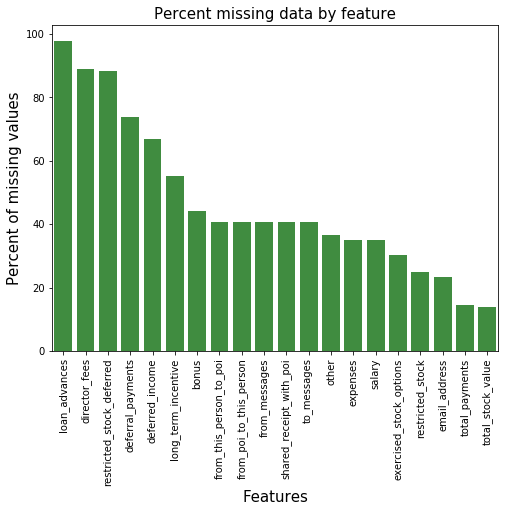

In [268]:
def missingdata(data):
    total = data.isnull().sum().sort_values(ascending = False)
    percent = (data.isnull().sum()/data.isnull().count()*100).sort_values(ascending = False)
    ms=pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    ms= ms[ms["Percent"] > 0]
    f,ax =plt.subplots(figsize=(8,6))
    plt.xticks(rotation='90')
    fig=sns.barplot(ms.index, ms["Percent"],color="green",alpha=0.8)
    plt.xlabel('Features', fontsize=15)
    plt.ylabel('Percent of missing values', fontsize=15)
    plt.title('Percent missing data by feature', fontsize=15)
    return ms
missingdata(enron_df)

In [269]:
enron_df.drop(missing_records_list, axis=1, inplace = True)

,Total,Percent
long_term_incentive,80,55.172414
bonus,64,44.137931
to_messages,59,40.689655
shared_receipt_with_poi,59,40.689655
from_this_person_to_poi,59,40.689655
from_poi_to_this_person,59,40.689655
from_messages,59,40.689655
other,53,36.551724
salary,51,35.172414
expenses,51,35.172414


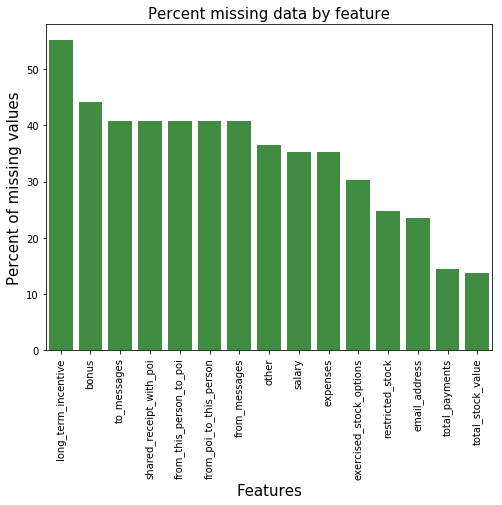

In [270]:
missingdata(enron_df)

Let's replace missing values with zero, and mark them in a new column.

In [271]:
# Iterate through the columns
for col in list(enron_df.columns):
    # create marker for missing columns
    enron_df[col+'_missing'] = pd.isna(enron_df[col])
    if col not in ['email_address', 'poi']:
        #fill NaN with zero
        enron_df[col].fillna(0, inplace = True)
    # innocent until proven guilty
    elif col == 'poi':
        enron_df[col].fillna(False, inplace = True)
    # we will ignore email_address as we do not need it for algorithms



In [272]:
enron_df.head()

,bonus,email_address,exercised_stock_options,expenses,from_messages,from_poi_to_this_person,from_this_person_to_poi,long_term_incentive,other,poi,...,from_this_person_to_poi_missing,long_term_incentive_missing,other_missing,poi_missing,restricted_stock_missing,salary_missing,shared_receipt_with_poi_missing,to_messages_missing,total_payments_missing,total_stock_value_missing
METTS MARK,600000.0,mark.metts@enron.com,0.0,94299.0,29.0,38.0,1.0,0.0,1740.0,False,...,False,True,False,False,False,False,False,False,False,False
BAXTER JOHN C,1200000.0,NaN,6680544.0,11200.0,0.0,0.0,0.0,1586055.0,2660303.0,False,...,True,False,False,False,False,False,True,True,False,False
ELLIOTT STEVEN,350000.0,steven.elliott@enron.com,4890344.0,78552.0,0.0,0.0,0.0,0.0,12961.0,False,...,True,True,False,False,False,False,True,True,False,False
CORDES WILLIAM R,0.0,bill.cordes@enron.com,651850.0,0.0,12.0,10.0,0.0,0.0,0.0,False,...,False,True,True,False,False,True,False,False,True,False
HANNON KEVIN P,1500000.0,kevin.hannon@enron.com,5538001.0,34039.0,32.0,32.0,21.0,1617011.0,11350.0,True,...,False,False,False,False,False,False,False,False,False,False


In [273]:
print('check the nan value in train data')
print(enron_df.isnull().sum())

check the nan value in train data
bonus                               0
email_address                      34
exercised_stock_options             0
expenses                            0
from_messages                       0
from_poi_to_this_person             0
from_this_person_to_poi             0
long_term_incentive                 0
other                               0
poi                                 0
restricted_stock                    0
salary                              0
shared_receipt_with_poi             0
to_messages                         0
total_payments                      0
total_stock_value                   0
bonus_missing                       0
email_address_missing               0
exercised_stock_options_missing     0
expenses_missing                    0
from_messages_missing               0
from_poi_to_this_person_missing     0
from_this_person_to_poi_missing     0
long_term_incentive_missing         0
other_missing                       0
poi_missing     

## Outlier Exploration

First, I want to check the ratio of messages sent to POI to total number of messages sent.

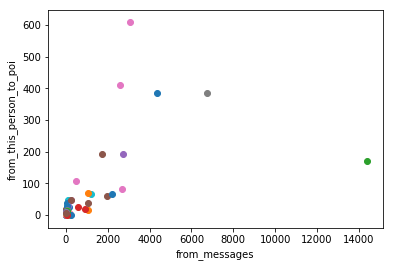

In [274]:
features = ["from_messages", "from_this_person_to_poi"]
data = featureFormat(data_dict, features)


# your code below

for point in data:
    salary = point[0]
    bonus = point[1]
    plt.scatter(salary, bonus)

plt.xlabel(features[0])
plt.ylabel(features[1])
plt.show()

In [275]:
enron_df[enron_df.from_messages == 14368].T

,KAMINSKI WINCENTY J
bonus,400000
email_address,vince.kaminski@enron.com
exercised_stock_options,850010
expenses,83585
from_messages,14368
from_poi_to_this_person,41
from_this_person_to_poi,171
long_term_incentive,323466
other,4669
poi,False


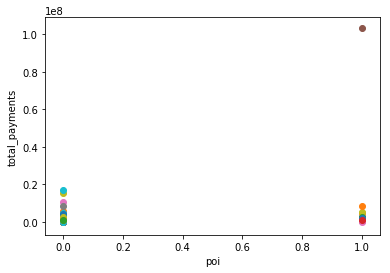

In [276]:
features = ["poi", "total_payments"]
data = featureFormat(data_dict, features)


for point in data:
    salary = point[0]
    bonus = point[1]
    plt.scatter(salary, bonus)

plt.xlabel(features[0])
plt.ylabel(features[1])
plt.show()

In [277]:
enron_df[enron_df.total_payments == enron_df.total_payments.max()].T

,LAY KENNETH L
bonus,7e+06
email_address,kenneth.lay@enron.com
exercised_stock_options,3.43484e+07
expenses,99832
from_messages,36
from_poi_to_this_person,123
from_this_person_to_poi,16
long_term_incentive,3.6e+06
other,1.03597e+07
poi,True


This looks like a normal record that should not be removed.

## Feature Selection

First, I want to create a feature to relate POI emails sent and recieved.

In [278]:
enron_df['from_this_person_ratio'] = enron_df.from_this_person_to_poi/enron_df.from_messages
enron_df['to_this_person_ratio'] = (enron_df.from_poi_to_this_person + enron_df.shared_receipt_with_poi)/enron_df.to_messages


In [279]:
enron_df['from_this_person_ratio'].fillna(0, inplace = True)
enron_df['to_this_person_ratio'].fillna(0, inplace = True)

In [280]:
my_dataset = enron_df.copy()

In [281]:

my_dataset = my_dataset.drop(['email_address', 'from_messages', 'from_this_person_to_poi', 'from_poi_to_this_person', 'shared_receipt_with_poi', 'to_messages', 'poi_missing' ], axis=1)
my_dataset.head()

,bonus,exercised_stock_options,expenses,long_term_incentive,other,poi,restricted_stock,salary,total_payments,total_stock_value,...,long_term_incentive_missing,other_missing,restricted_stock_missing,salary_missing,shared_receipt_with_poi_missing,to_messages_missing,total_payments_missing,total_stock_value_missing,from_this_person_ratio,to_this_person_ratio
METTS MARK,600000.0,0.0,94299.0,0.0,1740.0,False,585062.0,365788.0,1061827.0,585062.0,...,True,False,False,False,False,False,False,False,0.034483,0.916976
BAXTER JOHN C,1200000.0,6680544.0,11200.0,1586055.0,2660303.0,False,3942714.0,267102.0,5634343.0,10623258.0,...,False,False,False,False,True,True,False,False,0.000000,0.000000
ELLIOTT STEVEN,350000.0,4890344.0,78552.0,0.0,12961.0,False,1788391.0,170941.0,211725.0,6678735.0,...,True,False,False,False,True,True,False,False,0.000000,0.000000
CORDES WILLIAM R,0.0,651850.0,0.0,0.0,0.0,False,386335.0,0.0,0.0,1038185.0,...,True,True,False,True,False,False,True,False,0.000000,0.089005
HANNON KEVIN P,1500000.0,5538001.0,34039.0,1617011.0,11350.0,True,853064.0,243293.0,288682.0,6391065.0,...,False,False,False,False,False,False,False,False,0.656250,1.021053


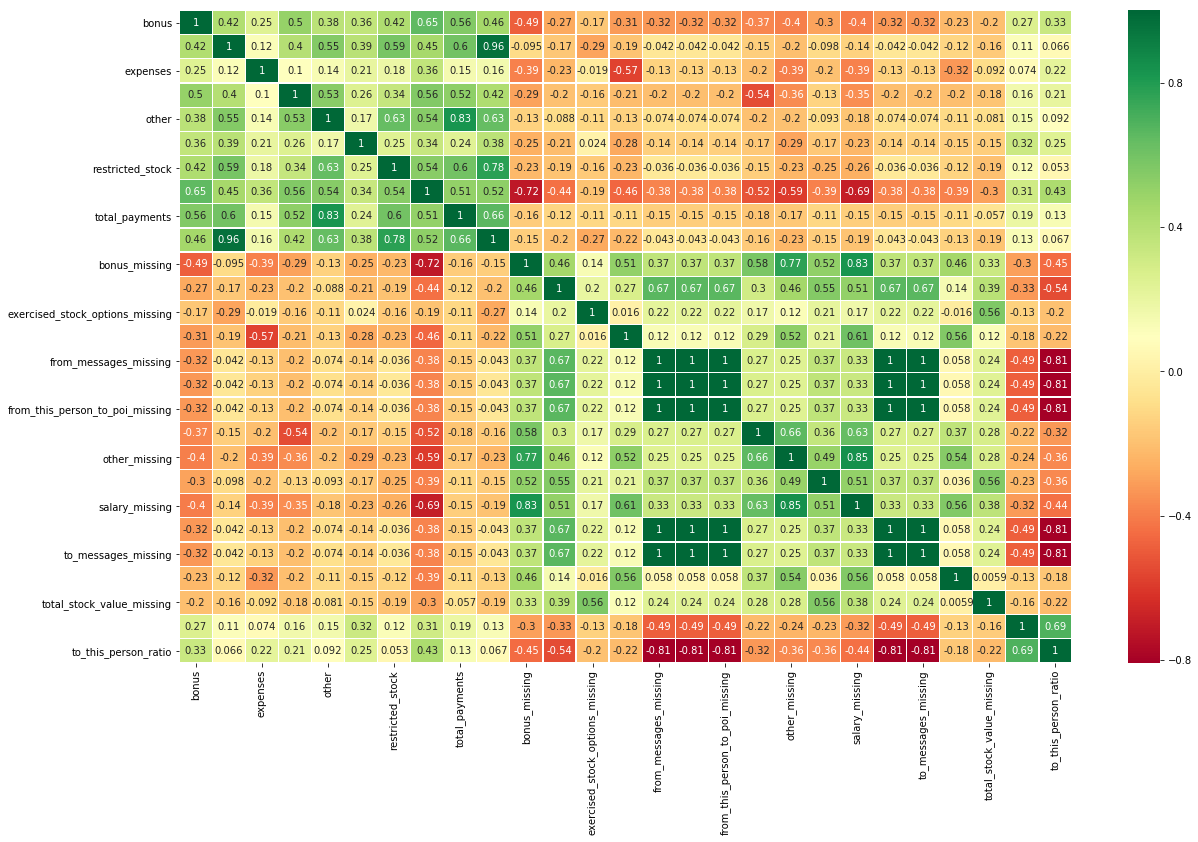

In [282]:
sns.heatmap(my_dataset.corr(),annot=True,cmap='RdYlGn',linewidths=0.2) #data.corr()-->correlation matrix
fig=plt.gcf()
fig.set_size_inches(20,12)
plt.show()

The above chart shows us that all email "missing" fields have 1:1 correlation. So we only need one.

Also, excercised_stock_options has a 0.96 correlation with total_stock_value, so we can just keep one.

In [283]:
my_dataset.rename(columns={'from_messages_missing': 'messages_missing'}, inplace=True)

In [284]:
my_dataset = my_dataset.drop(['from_this_person_to_poi_missing', 'from_poi_to_this_person_missing', 'shared_receipt_with_poi_missing', 'to_messages_missing',  'exercised_stock_options', 'exercised_stock_options_missing'], axis=1)
my_dataset.head()

,bonus,expenses,long_term_incentive,other,poi,restricted_stock,salary,total_payments,total_stock_value,bonus_missing,...,expenses_missing,messages_missing,long_term_incentive_missing,other_missing,restricted_stock_missing,salary_missing,total_payments_missing,total_stock_value_missing,from_this_person_ratio,to_this_person_ratio
METTS MARK,600000.0,94299.0,0.0,1740.0,False,585062.0,365788.0,1061827.0,585062.0,False,...,False,False,True,False,False,False,False,False,0.034483,0.916976
BAXTER JOHN C,1200000.0,11200.0,1586055.0,2660303.0,False,3942714.0,267102.0,5634343.0,10623258.0,False,...,False,True,False,False,False,False,False,False,0.000000,0.000000
ELLIOTT STEVEN,350000.0,78552.0,0.0,12961.0,False,1788391.0,170941.0,211725.0,6678735.0,False,...,False,True,True,False,False,False,False,False,0.000000,0.000000
CORDES WILLIAM R,0.0,0.0,0.0,0.0,False,386335.0,0.0,0.0,1038185.0,True,...,True,False,True,True,False,True,True,False,0.000000,0.089005
HANNON KEVIN P,1500000.0,34039.0,1617011.0,11350.0,True,853064.0,243293.0,288682.0,6391065.0,False,...,False,False,False,False,False,False,False,False,0.656250,1.021053


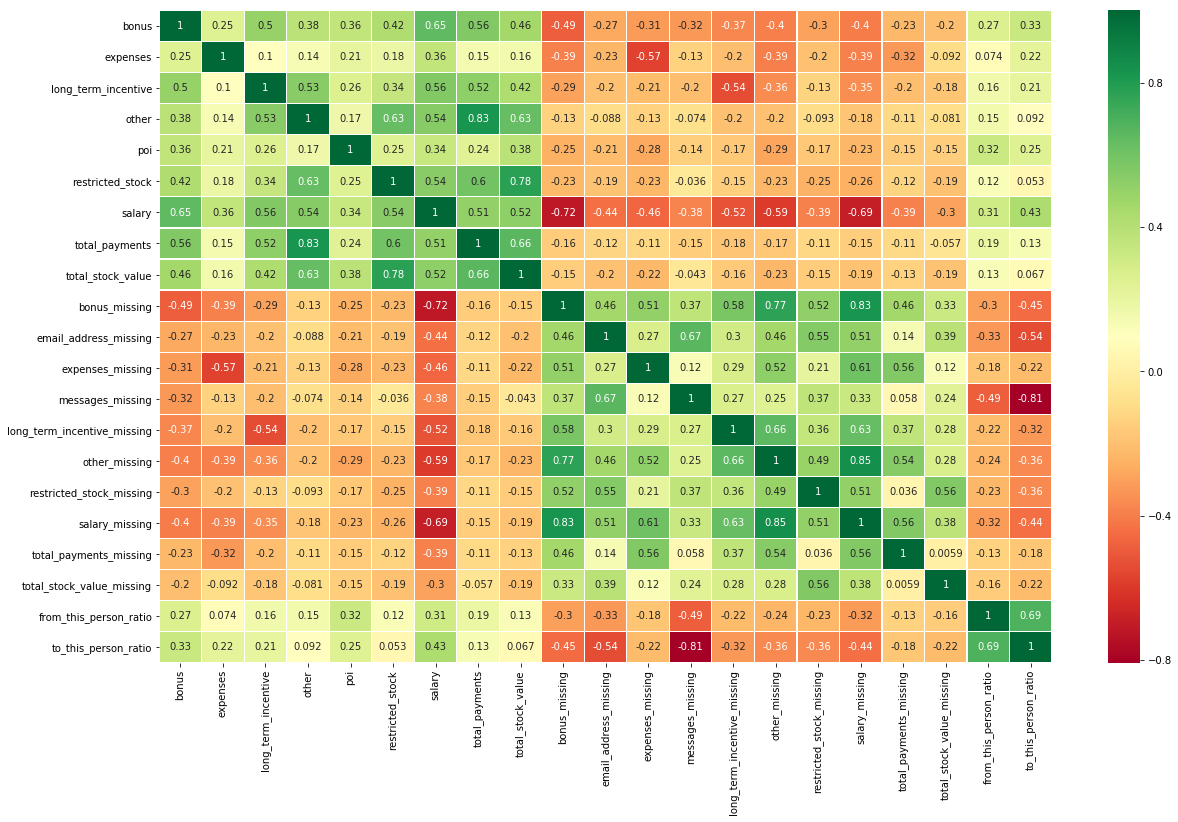

In [285]:
sns.heatmap(my_dataset.corr(),annot=True,cmap='RdYlGn',linewidths=0.2) #data.corr()-->correlation matrix
fig=plt.gcf()
fig.set_size_inches(20,12)
plt.show()

## Preparing data for algorithm (Train/test split)
We will begin by using 30% test size

In [286]:
from sklearn.model_selection import train_test_split
all_features = my_dataset.drop("poi",axis=1)
Targeted_feature = my_dataset["poi"]
X_train,X_test,y_train,y_test = train_test_split(all_features,Targeted_feature,test_size=0.3)
y_true = y_test
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((101, 20), (44, 20), (101,), (44,))

# Naive-Bayes classifier

In [287]:

### Task 4: Try a varity of classifiers
### Please name your classifier clf for easy export below.
### Note that if you want to do PCA or other multi-stage operations,
### you'll need to use Pipelines. For more info:
### http://scikit-learn.org/stable/modules/pipeline.html

# Provided to give you a starting point. Try a variety of classifiers.
from sklearn.naive_bayes import GaussianNB
clf = GaussianNB()
clf = clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

acc = metrics.accuracy_score(y_true, y_pred)
print(acc)


print('precision: ', metrics.precision_score(y_true, y_pred))
print('recall: ', metrics.recall_score(y_true, y_pred))

0.7954545454545454
precision:  0.14285714285714285
recall:  0.25


--------------The Accuracy of the model----------------------------
The accuracy of the Naive-Bayes Classifier is 79.55
The cross validated score for Naive-Bayes Classifier is: 85.29


Text(0.5, 1.05, 'Confusion_matrix')

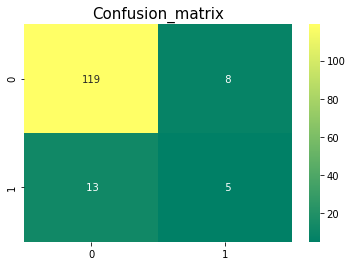

In [288]:
print('--------------The Accuracy of the model----------------------------')
print('The accuracy of the Naive-Bayes Classifier is', round(acc*100,2))

kfold = KFold(n_splits=10) # k=10, split the data into 10 equal parts

#score evaluation
result_rm=cross_val_score(clf,all_features,Targeted_feature,cv=10,scoring='accuracy')
print('The cross validated score for Naive-Bayes Classifier is:',round(result_rm.mean()*100,2))

#prediction
y_pred = cross_val_predict(clf,all_features,Targeted_feature,cv=10)

#for confusion matrix
sns.heatmap(metrics.confusion_matrix(Targeted_feature,y_pred),annot=True,fmt='3.0f',cmap="summer")
plt.title('Confusion_matrix', y=1.05, size=15)

# Decision Tree Classifier

In [289]:
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier(min_samples_split=25, random_state=42)
clf = clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

acc = metrics.accuracy_score(y_true, y_pred)
print(acc)

0.75


--------------The Accuracy of the model----------------------------
The accuracy of the Decision Tree Classifier is 75.0
The cross validated score for Decision Tree Classifier is: 82.67


Text(0.5, 1.05, 'Confusion_matrix')

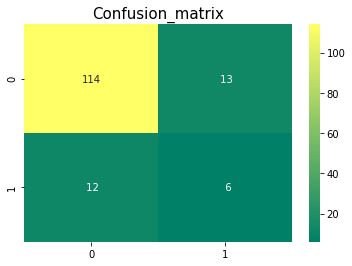

In [290]:
print('--------------The Accuracy of the model----------------------------')
print('The accuracy of the Decision Tree Classifier is', round(acc*100,2))

kfold = KFold(n_splits=10) # k=10, split the data into 10 equal parts

#score evaluation
result_rm=cross_val_score(clf,all_features,Targeted_feature,cv=10,scoring='accuracy')
print('The cross validated score for Decision Tree Classifier is:',round(result_rm.mean()*100,2))

#prediction
y_pred = cross_val_predict(clf,all_features,Targeted_feature,cv=10)

#for confusion matrix
sns.heatmap(metrics.confusion_matrix(Targeted_feature,y_pred),annot=True,fmt='3.0f',cmap="summer")
plt.title('Confusion_matrix', y=1.05, size=15)

# Random Forest Classifier

In [291]:

clf = RandomForestClassifier( random_state=42)
clf = clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

acc = metrics.accuracy_score(y_true, y_pred)
print('accuracy: ', acc)

print('precision: ', metrics.precision_score(y_true, y_pred))
print('recall: ', metrics.recall_score(y_true, y_pred))

accuracy:  0.8636363636363636
precision:  0.25
recall:  0.25


--------------The Accuracy of the model----------------------------
The accuracy of the Random Forest Classifier is 86.36
The cross validated score for Random Forest Classifier is: 88.98


Text(0.5, 1.05, 'Confusion_matrix')

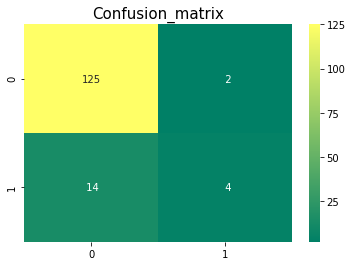

In [292]:
print('--------------The Accuracy of the model----------------------------')
print('The accuracy of the Random Forest Classifier is', round(acc*100,2))

kfold = KFold(n_splits=10) # k=10, split the data into 10 equal parts

#score evaluation
result_rm=cross_val_score(clf,all_features,Targeted_feature,cv=10,scoring='accuracy')
print('The cross validated score for Random Forest Classifier is:',round(result_rm.mean()*100,2))

#prediction
y_pred = cross_val_predict(clf,all_features,Targeted_feature,cv=10)

 #for confusion matrix
sns.heatmap(metrics.confusion_matrix(Targeted_feature,y_pred),annot=True,fmt='3.0f',cmap="summer")
plt.title('Confusion_matrix', y=1.05, size=15)

# SVM

In [293]:
from sklearn.svm import SVC
clf = SVC(C=1000.0, kernel='sigmoid', random_state=42)
clf = clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

acc = metrics.accuracy_score(y_true, y_pred)
print('accuracy: ', acc)


print('precision: ', metrics.precision_score(y_true, y_pred))
print('recall: ', metrics.recall_score(y_true, y_pred))

accuracy:  0.8636363636363636
precision:  0.0
recall:  0.0


--------------The Accuracy of the model----------------------------
The accuracy of the Random Forest Classifier is 86.36
The cross validated score for Random Forest Classifier is: 76.48


Text(0.5, 1.05, 'Confusion_matrix')

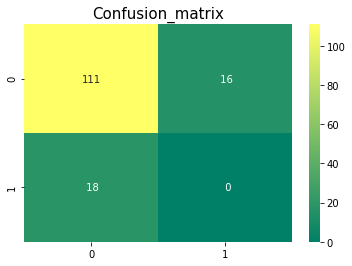

In [294]:
print('--------------The Accuracy of the model----------------------------')
print('The accuracy of the Random Forest Classifier is', round(acc*100,2))

kfold = KFold(n_splits=10) # k=10, split the data into 10 equal parts

#score evaluation
result_rm=cross_val_score(clf,all_features,Targeted_feature,cv=10,scoring='accuracy')
print('The cross validated score for Random Forest Classifier is:',round(result_rm.mean()*100,2))

#prediction
y_pred = cross_val_predict(clf,all_features,Targeted_feature,cv=10)

 #for confusion matrix
sns.heatmap(metrics.confusion_matrix(Targeted_feature,y_pred),annot=True,fmt='3.0f',cmap="summer")
plt.title('Confusion_matrix', y=1.05, size=15)

# Tuning

Let's tune our best option, the Random Forest Classifier

First, I want to try using the Grid Search tool that automatically finds the best tuning...

In [392]:
# Random Forest Classifier Parameters tunning 
clf = RandomForestClassifier()
n_estim=range(10,200,10)
## Search grid for optimal parameters
param_grid = {"n_estimators" :n_estim, 
              'criterion': ['gini', 'entropy'], 
              'min_samples_split': [2, 3, 8, 14, 25],
             'min_samples_leaf' : [1, 2, 3],
             'max_features' : ['auto', 'log2', None],
             'verbose' : [0,1]}


model_rf = GridSearchCV(clf,param_grid = param_grid, cv=5, scoring="recall", n_jobs= 4, verbose = 1)
model_rf.fit(X_train,y_train)
# Best score
print(model_rf.best_score_)
#best estimator
model_rf.best_estimator_

Fitting 5 folds for each of 3420 candidates, totalling 17100 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    6.7s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   20.7s
[Parallel(n_jobs=4)]: Done 659 tasks      | elapsed:   46.1s
[Parallel(n_jobs=4)]: Done 1348 tasks      | elapsed:  1.4min
[Parallel(n_jobs=4)]: Done 1936 tasks      | elapsed:  2.3min
[Parallel(n_jobs=4)]: Done 2853 tasks      | elapsed:  3.2min
[Parallel(n_jobs=4)]: Done 4083 tasks      | elapsed:  4.5min
[Parallel(n_jobs=4)]: Done 5583 tasks      | elapsed:  5.9min
[Parallel(n_jobs=4)]: Done 7283 tasks      | elapsed:  7.5min
[Parallel(n_jobs=4)]: Done 9150 tasks      | elapsed:  9.3min
[Parallel(n_jobs=4)]: Done 11119 tasks      | elapsed: 11.1min
[Parallel(n_jobs=4)]: Done 13419 tasks      | elapsed: 13.1min
[Parallel(n_jobs=4)]: Done 15444 tasks      | elapsed: 15.5min


0.3399339933993399


[Parallel(n_jobs=4)]: Done 17100 out of 17100 | elapsed: 17.0min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=2, min_samples_split=14,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=1,
            warm_start=False)

After optimizing for both accuracy and recall, below is what I've chosen to use. I had to choose between the two to avoid over/under fitting!

In [420]:

clf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=2, min_samples_split=10,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=42, verbose=0,
            warm_start=False)
clf = clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
y_true = y_test

acc = metrics.accuracy_score(y_true, y_pred)
print('accuracy: ', acc)

print('precision: ', metrics.precision_score(y_true, y_pred))
print('recall: ', metrics.recall_score(y_true, y_pred))

accuracy:  0.9090909090909091
precision:  0.5
recall:  0.25


--------------The Accuracy of the model----------------------------
The accuracy of the Random Forest Classifier is 90.91
The cross validated score for Random Forest Classifier is: 87.6


Text(0.5, 1.05, 'Confusion_matrix')

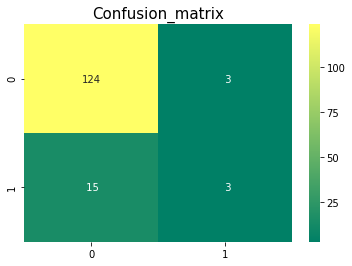

In [421]:
print('--------------The Accuracy of the model----------------------------')
print('The accuracy of the Random Forest Classifier is', round(acc*100,2))

kfold = KFold(n_splits=10) # k=10, split the data into 10 equal parts

#score evaluation
result_rm=cross_val_score(clf,all_features,Targeted_feature,cv=10,scoring='accuracy')
print('The cross validated score for Random Forest Classifier is:',round(result_rm.mean()*100,2))

#prediction
y_pred = cross_val_predict(clf,all_features,Targeted_feature,cv=10)

#for confusion matrix
sns.heatmap(metrics.confusion_matrix(Targeted_feature,y_pred),annot=True,fmt='3.0f',cmap="summer")
plt.title('Confusion_matrix', y=1.05, size=15)

# Check with Tester data


### Prepare data for export

In [422]:
features_list = list(my_dataset.columns)
features_list.remove('poi')
features_list = ['poi'] + features_list

In [423]:
final_dataset = my_dataset.T.to_dict()

In [424]:
### Task 6: Dump your classifier, dataset, and features_list so anyone can
### check your results. You do not need to change anything below, but make sure
### that the version of poi_id.py that you submit can be run on its own and
### generates the necessary .pkl files for validating your results.

dump_classifier_and_data(clf, final_dataset, features_list)

In [425]:
tester.main()


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=2, min_samples_split=10,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False)
	Accuracy: 0.87727	Precision: 0.37500	Recall: 0.12000	F1: 0.18182	F2: 0.13889
	Total predictions:  440	True positives:    6	False positives:   10	False negatives:   44	True negatives:  380



My precision and recall did not remain the same as my tuned model, we must have overfitted. I want to go back to Naive Bayes because this is such a small dataset that I think could benefit from a simpler model. Let's try this again...

# Final Model

In [426]:
# Random Forest Classifier Parameters tunning 
clf = GaussianNB()
n_estim=[0.0,0.1,0.01,0.05,0.001,0.0001,0.0005]
## Search grid for optimal parameters
param_grid = {"var_smoothing" :n_estim}


model_rf = GridSearchCV(clf,param_grid = param_grid, cv=5, scoring="accuracy", n_jobs= 4, verbose = 1)
model_rf.fit(X_train,y_train)
# Best score
print(model_rf.best_score_)
#best estimator
model_rf.best_estimator_

Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


0.8712871287128713


[Parallel(n_jobs=4)]: Done  28 out of  35 | elapsed:    4.7s remaining:    1.2s
[Parallel(n_jobs=4)]: Done  35 out of  35 | elapsed:    4.7s finished


GaussianNB(priors=None, var_smoothing=0.01)

accuracy:  0.8409090909090909
precision:  0.2
recall:  0.25
--------------The Accuracy of the model----------------------------
The accuracy of the Naive Bayes Classifier is 84.09
The cross validated score for Naive Bayes Classifier is: 83.96


Text(0.5, 1.05, 'Confusion_matrix')

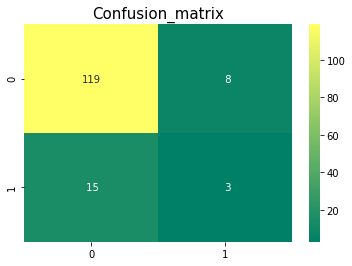

In [427]:

clf = GaussianNB(var_smoothing=0.01)
clf = clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
y_true = y_test
    
acc = metrics.accuracy_score(y_true, y_pred)
print('accuracy: ', acc)



print('precision: ', metrics.precision_score(y_true, y_pred))
print('recall: ', metrics.recall_score(y_true, y_pred))

print('--------------The Accuracy of the model----------------------------')
print('The accuracy of the Naive Bayes Classifier is', round(acc*100,2))

kfold = KFold(n_splits=10) # k=10, split the data into 10 equal parts

#score evaluation
result_rm=cross_val_score(clf,all_features,Targeted_feature,cv=10,scoring='accuracy')
print('The cross validated score for Naive Bayes Classifier is:',round(result_rm.mean()*100,2))

#prediction
y_pred = cross_val_predict(clf,all_features,Targeted_feature,cv=10)

 #for confusion matrix
sns.heatmap(metrics.confusion_matrix(Targeted_feature,y_pred),annot=True,fmt='3.0f',cmap="summer")
plt.title('Confusion_matrix', y=1.05, size=15)

In [428]:
dump_classifier_and_data(clf, final_dataset, features_list)

In [429]:
tester.main()

GaussianNB(priors=None, var_smoothing=0.01)
	Accuracy: 0.87273	Precision: 0.41667	Recall: 0.30000	F1: 0.34884	F2: 0.31780
	Total predictions:  440	True positives:   15	False positives:   21	False negatives:   35	True negatives:  369

